# Assignment: Fraud Detection
## Week 3 Assignment
### Ravi Kasarla
```
Creation Date: 12-SEP-2019
Last Update Date: 12-SEP-2019
Initial Source Code: https://www.kaggle.com/rkasarla/ieee-simple-xgboost/edit
Details about data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-624618
How all works togeather: https://www.kaggle.com/c/ieee-fraud-detection/discussion/107697#latest-624504
Chec these out:
importance of each varaible: https://www.kaggle.com/c/ieee-fraud-detection/discussion/107877#latest-624517
K-fold: https://github.com/pourya-ir/Medium/blob/master/K-fold-target-enc/K-fold-Target-Encoding.ipynb
Categorical Features: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
```

In [74]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn as sk
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import os
print(os.listdir("../data"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [3]:
from sklearn import preprocessing
import xgboost as xgb

In [4]:
train_transaction = pd.read_csv('../data/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../data/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../data/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../data/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../data/sample_submission.csv', index_col='TransactionID')

### In order to test how accurate the model is I am going to take train data and split to train / test

In [5]:
data = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)

In [6]:
# data.head(100)

In [7]:
# %%time
# data.fillna(value=data.mean(), inplace=True)

In [8]:
X = data.drop(['isFraud'],1)
y = data['isFraud']

In [9]:
X.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
y.head(3)

TransactionID
2987000    0
2987001    0
2987002    0
Name: isFraud, dtype: int64

### Plotting the missing values

In [75]:
def get_missing_vals(df):    
  
    null = df.isnull().sum()\
    .sort_values(ascending=False)\
    .reset_index(drop=False)\
    .rename(columns={'index':'var',0:'count'})
    
    #Generate Figure
    fig = plt.figure(figsize=(20,100))
    ax = fig.add_subplot(111)
    sns.barplot(data=null,y='var',x='count',color='teal')
    ax.set_ylabel('Variable',fontsize=18)
    ax.set_xlabel('Count',fontsize=18)
    ax.set_title('Missing Values per Variable',fontsize=28,y=1.02)

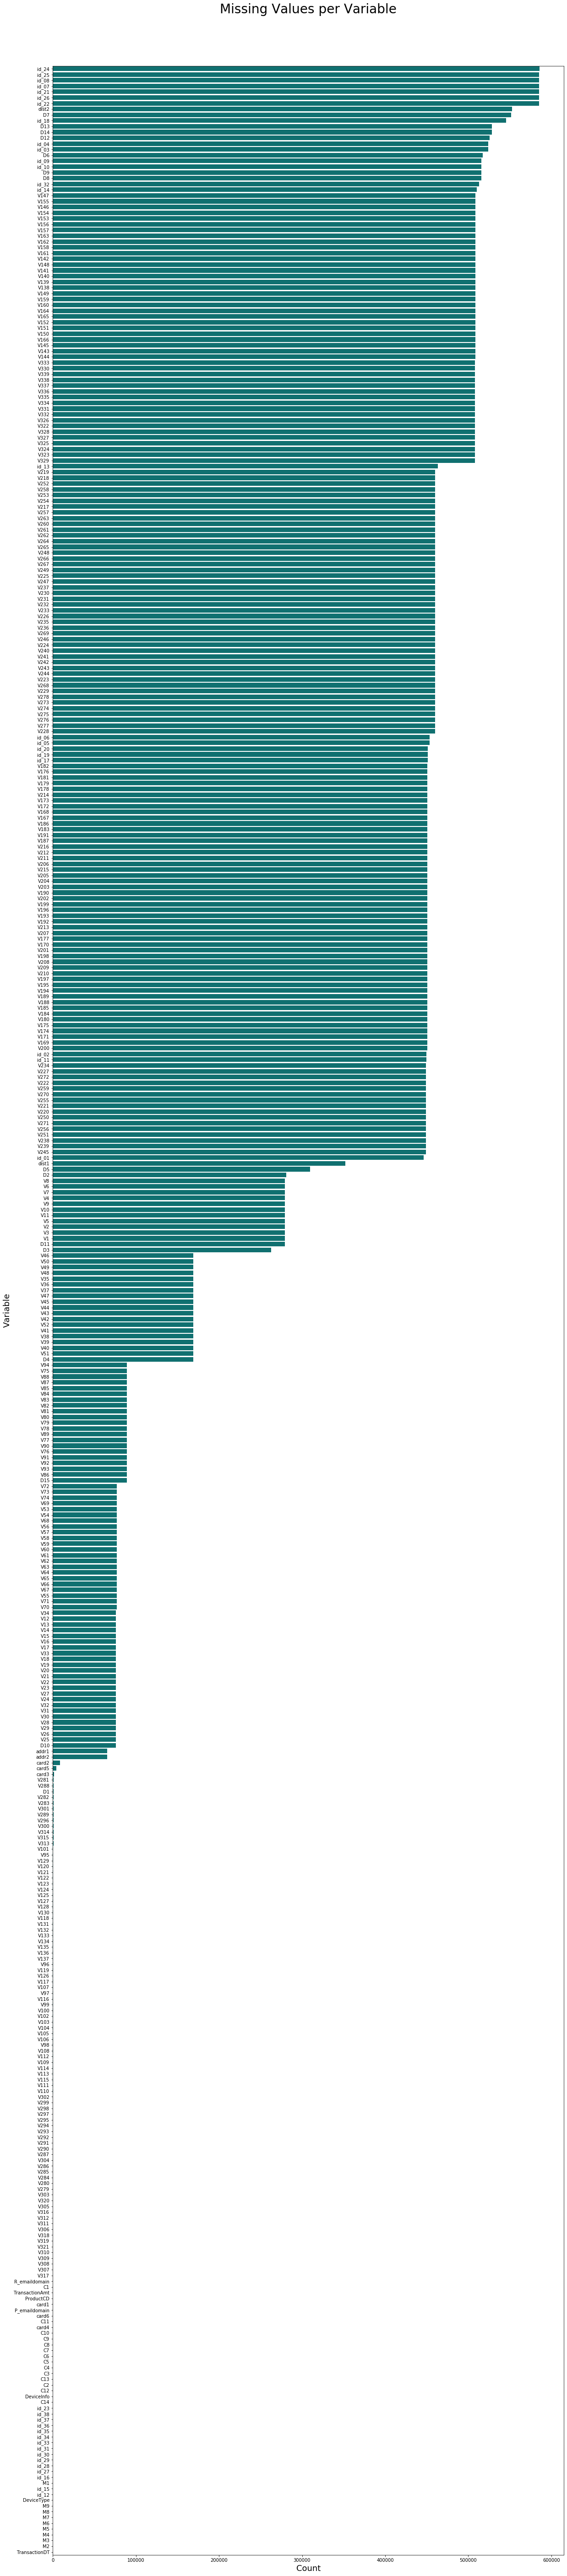

In [76]:
get_missing_vals(X)

In [77]:
X.shape

(590540, 432)

In [11]:
# Label Encoding
for f in X.columns:
    if X[f].dtype=='object' or X[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values))
        X[f] = lbl.transform(list(X[f].values))   

In [12]:
X.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,...,103,NaN,260,4,2,2,2,2,2,1742
2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,...,103,NaN,260,4,2,2,2,2,2,1742
2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,...,103,NaN,260,4,2,2,2,2,2,1742


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.03,random_state=101)

In [35]:
%%time
X_train.fillna(value=X_train.mean(), inplace=True)

Wall time: 1.29 s


In [36]:
%%time
X_test.fillna(value=X_test.mean(), inplace=True)

Wall time: 173 ms


In [17]:
scaler = sk.preprocessing.StandardScaler()

In [18]:
X_train = pd.DataFrame(data=scaler.fit_transform(X_train),columns = X_train.columns,index=X_train.index)
X_test  = pd.DataFrame(data=scaler.transform(X_test),columns = X_test.columns,index=X_test.index)

### Using sklearn.linear_model

In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
regression = LinearRegression()

In [67]:
%%time
model = regression.fit(X_train, y_train)

Wall time: 16.5 s


In [69]:
y_test_predict = model.predict(X_test)

In [70]:
y_test_predict

array([-0.0032171 , -0.00563124,  0.00032231, ...,  0.03095899,
       -0.00912101,  0.03197913])

In [71]:
y_test_predict_0_or_1 = np.where(y_test_predict > 0.5, 1, 0)

In [73]:
print(classification_report(y_test,y_test_predict_0_or_1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17102
           1       0.91      0.13      0.22       615

    accuracy                           0.97     17717
   macro avg       0.94      0.56      0.60     17717
weighted avg       0.97      0.97      0.96     17717



### Using XGBoost Classifier

In [37]:
%%time
clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

clf.fit(X_train, y_train)

Wall time: 1h 23min 21s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [40]:
# sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
# sample_submission.to_csv('simple_xgboost.csv')

In [42]:
y_test_predict = clf.predict_proba(X_test)[:,1]

In [54]:
y_test_predict.shape

(17717,)

In [55]:
y_test.shape

(17717,)

In [57]:
y_test_predict

array([0.00612152, 0.00221279, 0.00702995, ..., 0.0214296 , 0.00073576,
       0.0063057 ], dtype=float32)

In [60]:
y_test.head(2)

TransactionID
3514401    0
3013442    0
Name: isFraud, dtype: int64

In [61]:
y_test_predict_0_or_1 = np.where(y_test_predict > 0.5, 1, 0)

In [62]:
y_test_predict_0_or_1

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
print(classification_report(y_test,y_test_predict_0_or_1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     17102
           1       0.96      0.53      0.68       615

    accuracy                           0.98     17717
   macro avg       0.97      0.76      0.84     17717
weighted avg       0.98      0.98      0.98     17717



### Using Tensorflow

In [26]:
feat_cols = []
for f in range(len(X_train.columns)):
    feat_cols.append((tf.feature_column.numeric_column(X_train.columns[f])))

In [27]:
input_func=tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=50,num_epochs=None,shuffle=True)

In [28]:
%%time
# model = tf.estimator.LinearClassifier(feature_columns=feat_cols)
model = tf.estimator.DNNClassifier(feature_columns=feat_cols, hidden_units=[512,512,512,512])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\USWU32~1\\AppData\\Local\\Temp\\tmpwq8d8oix', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000024DF03785C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Wall time: 35 ms


In [29]:
%%time
model.train(input_fn=input_func,steps=8000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `

INFO:tensorflow:global_step/sec: 17.6056
INFO:tensorflow:loss = 11.459431, step = 4901 (5.686 sec)
INFO:tensorflow:global_step/sec: 17.646
INFO:tensorflow:loss = 10.319669, step = 5001 (5.668 sec)
INFO:tensorflow:global_step/sec: 17.7936
INFO:tensorflow:loss = 7.4709024, step = 5101 (5.617 sec)
INFO:tensorflow:global_step/sec: 18.4027
INFO:tensorflow:loss = 10.572217, step = 5201 (5.429 sec)
INFO:tensorflow:global_step/sec: 18.7196
INFO:tensorflow:loss = 5.625937, step = 5301 (5.348 sec)
INFO:tensorflow:global_step/sec: 18.1389
INFO:tensorflow:loss = 14.297477, step = 5401 (5.518 sec)
INFO:tensorflow:global_step/sec: 18.608
INFO:tensorflow:loss = 10.811248, step = 5501 (5.369 sec)
INFO:tensorflow:global_step/sec: 18.235
INFO:tensorflow:loss = 1.7327021, step = 5601 (5.483 sec)
INFO:tensorflow:global_step/sec: 17.4795
INFO:tensorflow:loss = 2.3547034, step = 5701 (5.720 sec)
INFO:tensorflow:global_step/sec: 18.1291
INFO:tensorflow:loss = 5.5737686, step = 5801 (5.516 sec)
INFO:tensorflo

### Evaluation
#### Create a prediction input function. Remember to only supprt X_test data and keep shuffle=False.

In [30]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)

In [31]:
predictions = list(model.predict(input_fn=pred_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from C:\Users\USWU32~1\AppData\Local\Temp\tmpwq8d8oix\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [32]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

In [34]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17102
           1       0.89      0.28      0.42       615

    accuracy                           0.97     17717
   macro avg       0.93      0.64      0.70     17717
weighted avg       0.97      0.97      0.97     17717

